# Image Captioning with Visual Attention 


## Preparation

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image
from io import BytesIO
import time
from textwrap import wrap
from tqdm import tqdm


import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)
from tensorflow.keras.applications import efficientnet as efn
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet import preprocess_input
print(tf.version.VERSION)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


In [2]:
import pkg_resources

# Get the list of currently installed packages and their versions
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

# Write the list to a requirements.txt file
with open('requirements.txt', 'w') as f:
    for package, version in installed_packages.items():
        f.write(f"{package}=={version}\n")

# The requirements.txt file is now saved in the current directory
# You can use the requirements.txt file to recreate the environment with the same package versions using pip:
# pip install -r requirements.txt

## Prepare dataset

We will use the [Flickr 30K](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) dataset.<br>

Credit to the [original paper](https://bryanplummer.com/Flickr30kEntities/) of the dataset.<br>

Bryan A. Plummer, Liwei Wang, Christopher M. Cervantes, Juan C. Caicedo, Julia Hockenmaier, and Svetlana Lazebnik, Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models, ICCV, 2015.

For the decoder, we will use the pretrained [EfficientNetB3](https://keras.io/api/applications/efficientnet/#efficientnetb3-function) model from `tf.keras.applications` as a feature extractor.<br>

`tf.keras.applications` is a pretrained model repository from Keras.

In [3]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 12500  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 300

# EfficientNetB3 takes (300, 300, 3) image as inputs
# and return features in (9, 9, 1536) shape
# FEATURE_EXTRACTOR = efn.EfficientNetB3(weights='imagenet', include_top=False)
FEATURE_EXTRACTOR = EfficientNetV2B3(weights='imagenet', include_top=False)

IMG_HEIGHT = 300
IMG_WIDTH = 300
IMG_CHANNELS = 3

52606240/52606240 [==============================] - 0s 0us/step


In [4]:
# # Create a dummy image tensor of the correct size
# dummy_input = tf.random.normal([1, 300, 300, 3])

# # Pass the dummy image through the model
# features = FEATURE_EXTRACTOR(dummy_input)

# # Print the shape of the resulting features
# print(features.shape)

In [5]:
#Set the Feature Shape according to the cell above.
FEATURES_SHAPE = (10, 10, 1536)

In [6]:
# FEATURE_EXTRACTOR.summary()

### Filter and Preprocess
Preprocess the dataset. The function below:
- resize image to (`IMG_HEIGHT`, `IMG_WIDTH`) shape
- apply data augmentations to image
- preprocess using EfficientNet preprocess_input function
- return image(`image_tensor`) and captions(`captions`) dictionary.

## Prepare Train Dataset

In [7]:
# Load the dataset
file_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'
data = pd.read_csv(file_path, sep='|', engine='python')
data.columns = [col.strip() for col in data.columns]
data['comment'] = data['comment'].astype(str)
data = data.reindex(columns=['comment_number', 'image_name', 'comment'])

In [8]:
BUFFER_SIZE = 2500

# Define the base path where images are stored
base_image_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'

# Assuming 'data' is a DataFrame containing your training data with columns 'image_name' and 'comment'
# Extract image paths and captions
image_paths = [os.path.join(base_image_path, fname) for fname in data['image_name']]
captions = data['comment'].tolist()

# Define the data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.03),
    tf.keras.layers.RandomBrightness(0.06),
    tf.keras.layers.RandomContrast(0.06),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.GaussianNoise(stddev=0.05),
])

# Define image processing function
def load_and_process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = data_augmentation(img)
    # img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img

def get_image_label_pair(image_path, caption):
    img = load_and_process_image(image_path)
    return {"image_tensor": img, "caption": caption}

# Create a dataset from the image paths and captions
trainds = tf.data.Dataset.from_tensor_slices((image_paths, captions))

# Map the function over the dataset
trainds = trainds.map(
    get_image_label_pair, num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle and prefetch the dataset
trainds = trainds.shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# BUFFER_SIZE = 2500
# GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(factor=0.02),
#     tf.keras.layers.RandomBrightness(0.05),
#     tf.keras.layers.RandomContrast(0.05),
#     tf.keras.layers.RandomZoom(0.05),
#     tf.keras.layers.GaussianNoise(stddev=0.05),
# ])

# def get_image_label_coco(example):
#     caption = example["captions"]["text"][random.randint(0,4)]  # only the first caption per image
#     img = example["image"]
#     img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     # Apply data augmentation
#     img = data_augmentation(img)
#     img = img / 255
#     return {"image_tensor": img, "caption": caption}

# trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

# trainds = trainds.map(
#     get_image_label_coco, num_parallel_calls=tf.data.AUTOTUNE
# ).shuffle(BUFFER_SIZE)
# trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

Dataset structure:  <_PrefetchDataset element_spec={'image_tensor': TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>


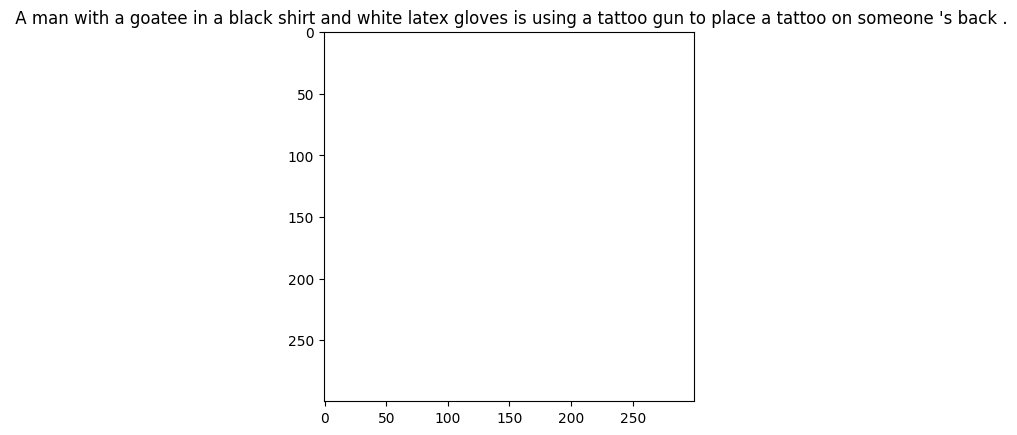

In [10]:
# Print the structure of the dataset
print("Dataset structure: ", trainds)

# Function to display a single example
def display_example(ds):
    for example in ds.take(1):
        image, caption = example["image_tensor"], example["caption"]
        plt.imshow(image)
        plt.title(caption.numpy().decode('utf-8'))
        plt.show()

display_example(trainds)

### Visualize Train Dataset

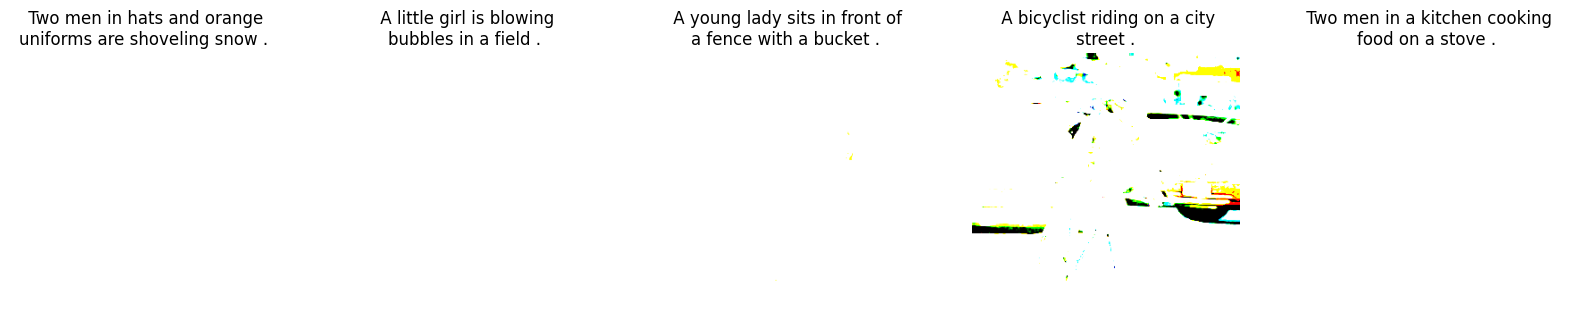

In [11]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))
for idx, data in enumerate(trainds.take(5)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Prepare Validation Dataset (COCO Captions)

In [12]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"

def get_image_label_coco(example):
    caption = example["captions"]["text"][random.randint(0,4)]
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return {"image_tensor": img, "caption": caption}


valds = tfds.load("coco_captions", split="val", data_dir=GCS_DIR)

valds = valds.map(
    get_image_label_coco, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
valds = valds.prefetch(buffer_size=tf.data.AUTOTUNE)

Dataset structure:  <_PrefetchDataset element_spec={'image_tensor': TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>


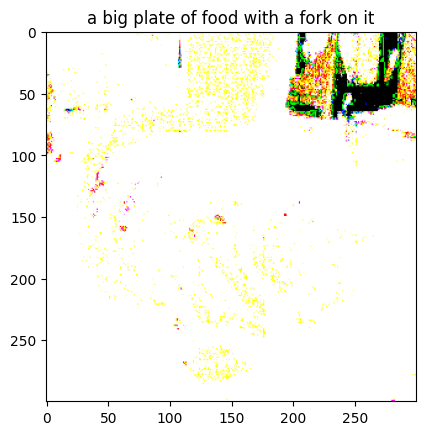

In [13]:
# Print the structure of the dataset
print("Dataset structure: ", valds)

display_example(valds)

### Visualize Validation Dataset

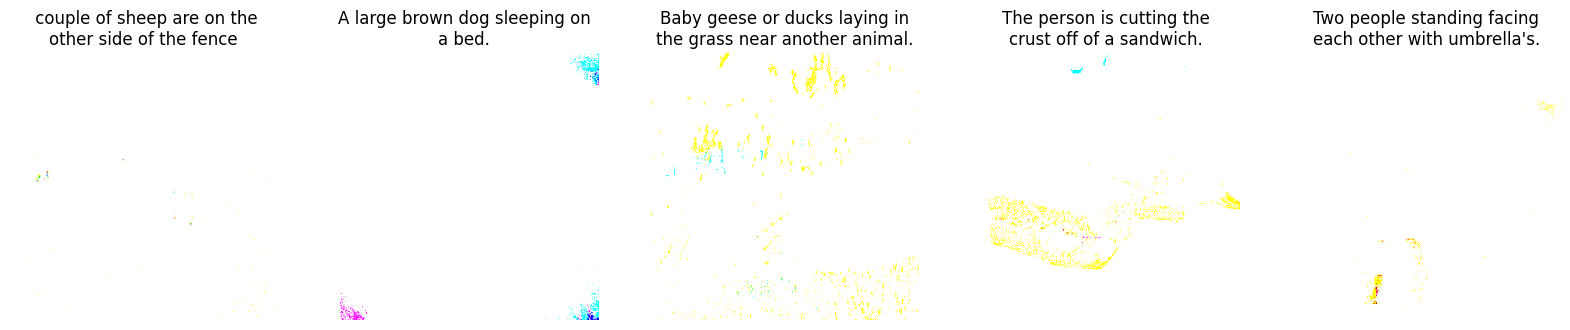

In [14]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))
for idx, data in enumerate(valds.take(5)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Text Preprocessing

Special tokens are added to each captions to represent the starts (`<start>`) and the ends (`<end>`) of sentences.<br>
During prediction, to get the captioning started, the `<start>` token is used and since captions are of variable length, the prediction are terminated when the `<end>` token is reached.

In [15]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data

trainds = trainds.map(add_start_end_token)
valds = valds.map(add_start_end_token)

## Preprocess and tokenize the captions

The text captions will be transformed into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top `VOCAB_SIZE` words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length `MAX_CAPTION_LEN`.

In [16]:
import time
start_time = time.time()
MAX_CAPTION_LEN = 64


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))
# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time for tokenization: {elapsed_time:.2f} seconds")

Elapsed time for tokenization: 1345.76 seconds



Let's try to tokenize a sample text 

In [17]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 227,  10,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [18]:
sample_train_captions = []
for d in trainds.take(5):
    sample_train_captions.append(d["caption"].numpy())

print(tokenizer(sample_train_captions))

tf.Tensor(
[[   3    2    9   10  592   38  439  405    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2    9 1581 7911   11    6   36    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2 2090    9  134    2  126    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [19]:
sample_train_captions

[b'<start>  A man is skateboarding down 2 stairs . <end>',
 b'<start>  A man shovels slush of the street . <end>',
 b'<start>  A black-haired man plays a guitar . <end>',
 b'<start>  A girl wearing flip-flop sandals swinging on a swing set in a park underneath fluffy white clouds . <end>',
 b'<start>  A group of people standing in front of a hut in a parking lot . <end>']

In [20]:
sample_validation_captions = []
for d in valds.take(5):
    sample_validation_captions.append(d["caption"].numpy())
    
print(tokenizer(sample_validation_captions))

tf.Tensor(
[[   3    2    9   97   10  317   71  892   11  127    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3   24 1732   30    7    6  396   11    2 1472  106    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2    9  121    7    6  349   25  174  128   38    6   36    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [21]:
sample_validation_captions

[b'<start> a man that is painting some kind of picture <end>',
 b'<start> Black television sitting on the corner of a bathroom wall.  <end>',
 b'<start> A man talking on the phone while he walks down the street.  <end>',
 b'<start> A person in blue jacket skiing down a mountain. <end>',
 b'<start> a person holding a blow dryer up to a dog sitting before the person. <end>']

Please note that all the sentenses starts and ends with the same token (e.g. '3' and '4'). These values represent start tokens and end tokens respectively.

IDs can also be converted back to original text.

In [22]:
for wordid in tokenizer([sample_train_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a man is skateboarding down 2 stairs <end>                                                        

In [23]:
for wordid in tokenizer([sample_validation_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a man that is painting some kind of picture <end>                                                      

Word <-> Index converters can be created using `StringLookup` layer.

In [24]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create a tf.data dataset for training
Applying the adapted tokenization to all the examples and create tf.data Dataset for training.

Labels are created by shifting texts from feature captions.<br>
If there is an input caption `"<start> I am jogging <end>"`, its label should be `"I am jogging <end> <padding>"`.<br>
With that, the model can try to learn to predict `I` from `<start>`.

The dataset should return tuples, where the first elements are features (`image_tensor` and `caption`) and the second elements are labels (target).### Create a tf.data dataset for training
Now Let's apply the adapted tokenization to all the examples and create tf.data Dataset for training.

Here note that we are also creating labels by shifting texts from feature captions.<br>
If we have an input caption `"<start> I love cats <end>"`, its label should be `"I love cats <end> <padding>"`.<br>
With that, our model can try to learn to predict `I` from `<start>`.

The dataset should return tuples, where the first elements are features (`image_tensor` and `caption`) and the second elements are labels (target).

In [25]:
BATCH_SIZE = 64


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_trainds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

batched_valds = (
    valds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


Let's take a look at some examples.

In [26]:
for (img, caption), label in batched_trainds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (64, 300, 300, 3)
Caption shape: (64, 64)
Label shape: (64, 64)
tf.Tensor(
[  3   2  13   5   2  48 311  99  10 284  45  46  59 393   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  13   5   2  48 311  99  10 284  45  46  59 393   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (64, 300, 300, 3)
Caption shape: (64, 64)
Label shape: (64, 64)
tf.Tensor(
[   3    2  713    8  740   18    6 2929    5    2 2276    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    

In [27]:
for (img, caption), label in batched_valds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (64, 300, 300, 3)
Caption shape: (64, 64)
Label shape: (64, 64)
tf.Tensor(
[   3    2 1353   30   68   16    2  632   11 3440    4    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2 1353   30   68   16    2  632   11 3440    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (64, 300, 300, 3)
Caption shape: (64, 64)
Label shape: (64, 64)
tf.Tensor(
[   3   14 5887    8 7959   15  359    7    2   91    5  227 1511  639
    4    0    0    0    0    0    0 

## Model
Design the image captioning model.<br>
The model consists of an image encoder and a caption decoder.

### Image Encoder
The struture of the image encoder is simple. It extracts features through a pre-trained model and passes them to a fully connected layer.

1. Features from convolutional layers of EfficientNetB3 output a vector of (Batch Size, 9, 9, 1536).
1. The vector is reshaped to (Batch Size, 81, 1536)
1. The vector is then compressed to a length of `ATTENTION_DIM` with a Dense Layer and return (Batch Size, 81, ATTENTION_DIM)
1. After that, the Attention layer attends over the image to predict the next word.

In [28]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, 
                       activation="relu",
                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 reshape (Reshape)           (None, 100, 1536)         0         
                                                                 
 dense (Dense)               (None, 100, 512)          786944    
                                                                 
Total params: 13717566 (52.33 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


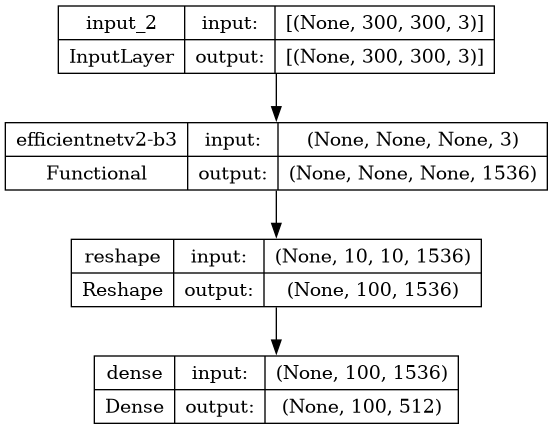

In [29]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()
tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

### Caption Decoder
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.
#### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. 

This is how it works:

<img src="https://user-images.githubusercontent.com/6895245/173408554-d4b6387b-248b-421e-8911-550d0561d001.png" alt="attention equation 1" width="800">

<img src="https://user-images.githubusercontent.com/6895245/173408648-38c6b582-a68b-4697-982a-1d885b83dd0b.png" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://user-images.githubusercontent.com/6895245/173408773-3781cacc-de00-49c6-9909-f6cd65a0501b.png" alt="attention equation 4" width="750">

This notebook implement Bahdanau-style attention using pre-defined `layers.AdditiveAttention`.

#### Decoder Steps

The decoder's task is to generate predictions for the next output token.

1. The decoder receives current word tokens as a batch.
1. It embeds the word tokens to `WORD_EMBEDDING_DIM` dimension.
1. GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
1. Luong-style attention attends over the encoder's output feature by using GRU outputs as a query.
1. The attention outputs and GRU outputs are added (skip connection), and normalized in a layer normalization layer.
1. It generates logit predictions for the next token based on the GRU output.

All the steps are defined using Keras Functional API, the instantiated layers that have trainable parameters will be reused as the layers and the weights are needed in inference phase.#### Decoder Steps

The decoder's job is to generate predictions for the next output token.

1. The decoder receives current word tokens as a batch.
1. It embeds the word tokens to `ATTENTION_DIM` dimension.
1. GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
1. Bahdanau-style attention attends over the encoder's output feature by using GRU outputs as a query.
1. The attention outputs and GRU outputs are added (skip connection), and normalized in a layer normalization layer.
1. It generates logit predictions for the next token based on the GRU output.

We can define all the steps in Keras Functional API, but please note that here we instantiate layers that have trainable parameters so that we reuse the layers and the weights in inference phase.

In [30]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, WORD_EMBEDDING_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
    dropout=0.4  # Add dropout
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = AdditiveAttention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE,
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))
decoder_output = decoder_output_dense(layer_norm_out)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              3750000   ['words[0][0]']               
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1250304   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                                  
 input_3 (InputLayer)        [(None, 100, 512)]           0         []                      

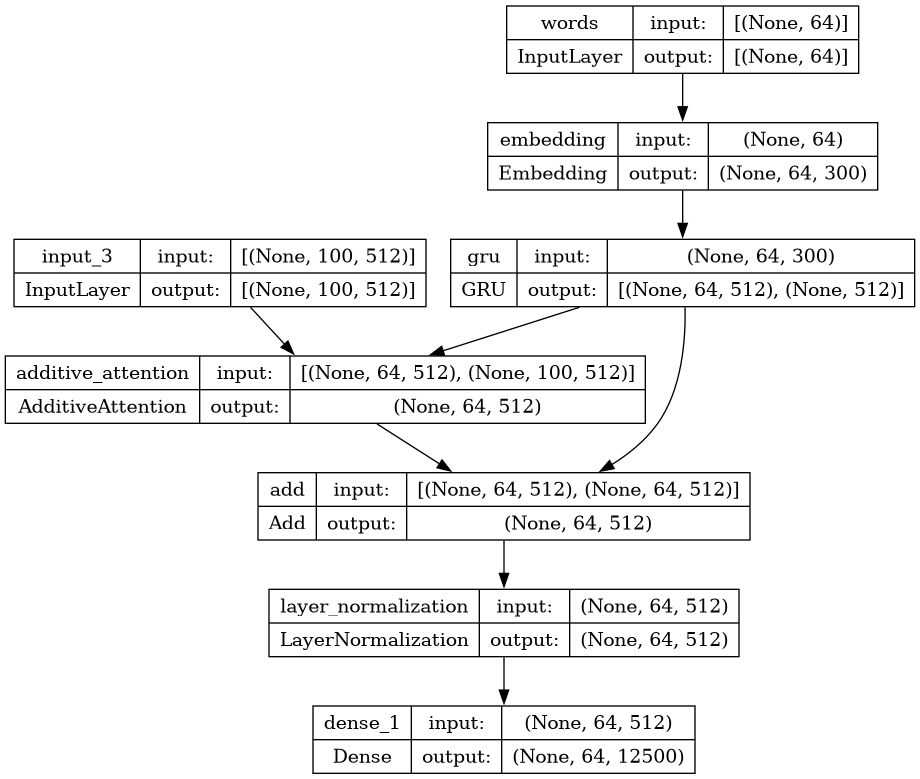

In [31]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
decoder.summary()
tf.keras.utils.plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)

### Training Model

After defining the encoder and the decoder. Both of them are combined into a complete model for training.<br>
The complete training model has two inputs (`image_input` and `word_input`, and an output (`decoder_output`). This definition should correspond to the definition of the dataset pipeline.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 efficientnetv2-b3 (Functio  (None, None, None, 1536)     1293062   ['input_2[0][0]']             
 nal)                                                     2                                       
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              3750000   ['words[0][0]']         

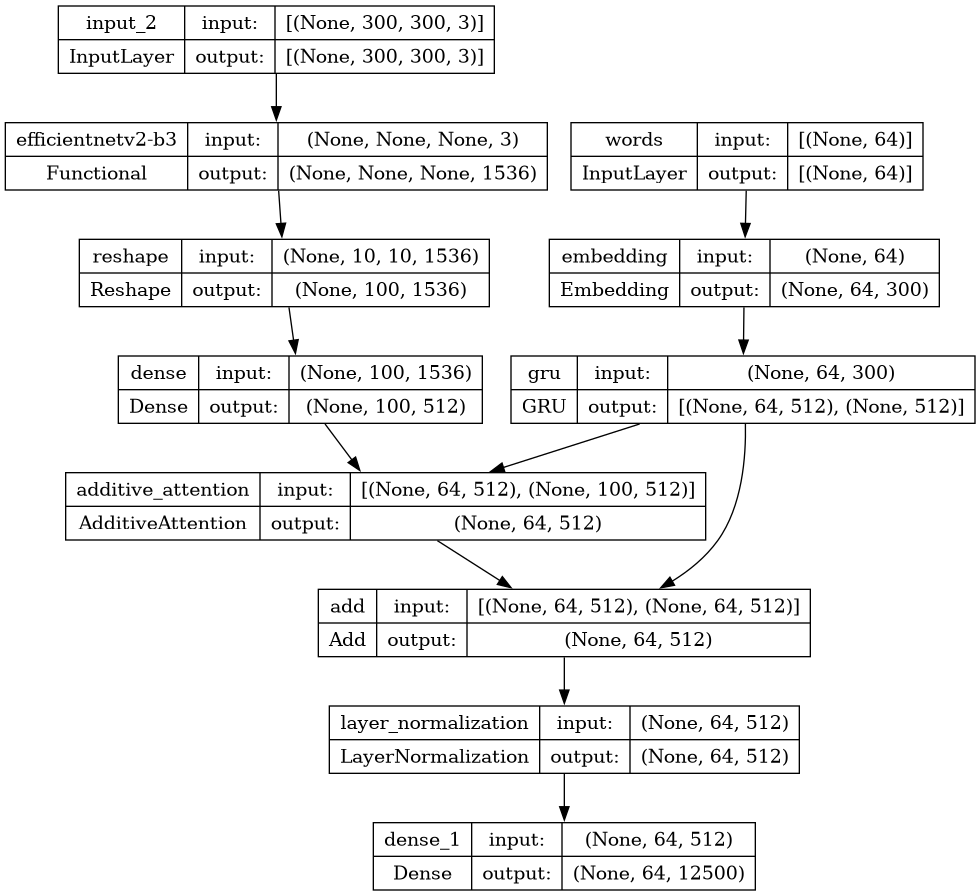

In [32]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)
image_caption_train_model.summary()
tf.keras.utils.plot_model(image_caption_train_model, to_file='image_caption_train_model.png', show_shapes=True, show_layer_names=True)

### Loss Function
The loss function is a simple cross-entropy, the padding (`0`) is needed to be removed when calculating it.<br>
The length of the sentence (non-0 part) is extracted, and compute the average of the loss only over the valid sentence part. 

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

Learning rate schedule: 1e-05 to 0.0005 to 9.85e-05


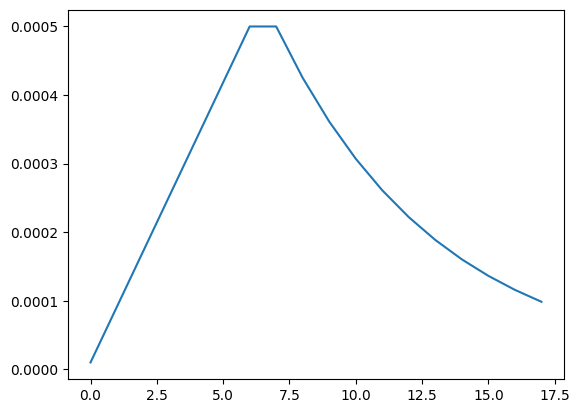

In [34]:
EPOCHS = 18
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint_image_caption_train_model.tf',
                                                monitor='val_loss', 
                                                save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  restore_best_weights=True)

LR_START = 1e-5
LR_MAX = 5e-4   # This is the initial learning rate
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# # Define the ReduceLROnPlateau callback
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=1,
#     verbose=1,
#     mode='min',
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0
# )

In [35]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

## Training loop

Train the model using the standard `model.fit` API.<br>

In [36]:
%%time
history = image_caption_train_model.fit(
    batched_trainds, 
    epochs=EPOCHS,
    validation_data=batched_valds,  # Include validation data here
    callbacks=[early_stopping, checkpoint, lr_callback], 
    verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/18


2024-01-04 02:57:58.866024: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2483/2483 [==============================] - 1700s 670ms/step - loss: 2.2637 - val_loss: 1.2912 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666667e-05.
Epoch 2/18
2483/2483 [==============================] - 1669s 665ms/step - loss: 1.0396 - val_loss: 0.8276 - lr: 9.1667e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.00017333333333333334.
Epoch 3/18
2483/2483 [==============================] - 1684s 671ms/step - loss: 0.7886 - val_loss: 0.7368 - lr: 1.7333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000255.
Epoch 4/18
2483/2483 [==============================] - 1693s 674ms/step - loss: 0.7230 - val_loss: 0.7101 - lr: 2.5500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003366666666666667.
Epoch 5/18
2483/2483 [==============================] - 1754s 699ms/step - loss: 0.6931 - val_loss: 0.6949 - lr: 3.3667e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0004183333333333334.
Epo

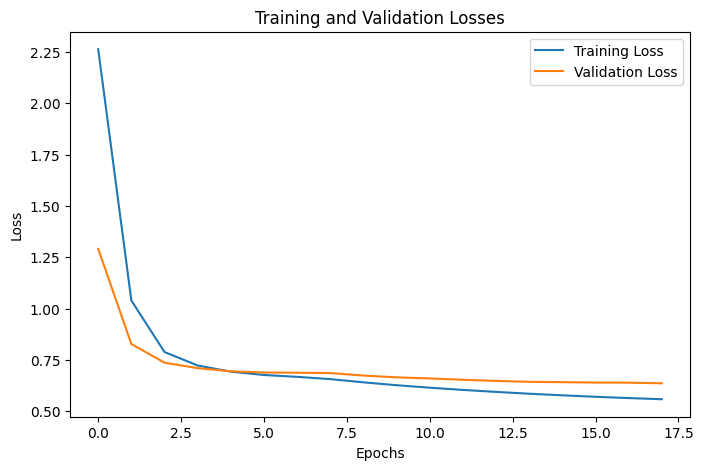

In [37]:
# Assuming 'history' is the return value of model.fit() during training
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Fine-Tune

In [38]:
# # Set the entire model's trainable flag to True (it is False by default)
# FEATURE_EXTRACTOR.trainable = True

# # Now choose how many layers to freeze and how many to unfreeze
# # Let's say we choose to unfreeze the top 50 layers
# for layer in FEATURE_EXTRACTOR.layers[:-30]:
#     layer.trainable = False
    
# # It's important to recompile the model after you make any changes to the `trainable` attribute of any layer
# image_caption_train_model.compile(
#     optimizer="adam",
#     loss=loss_function
# )

# LR_START = 1e-7  
# LR_MAX = 1e-6  
# LR_MIN = 1e-7  
# LR_RAMPUP_EPOCHS = 2  
# LR_SUSTAIN_EPOCHS = 0  
# LR_EXP_DECAY = .8

# def lrfn(epoch):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
#     return lr

# lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# # Resume training
# history_fine_tune = image_caption_train_model.fit(
#     batched_trainds, 
#     epochs=5,
#     validation_data=batched_valds,  # Include validation data here
#     callbacks=[early_stopping, checkpoint, lr_callback], 
#     verbose=1)

In [39]:
# # Assuming 'history' is the return value of model.fit() during training
# plt.figure(figsize=(8, 5))
# plt.plot(history_fine_tune.history['loss'], label='Training Loss')
# plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Losses in Fine Tuning Session')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

## Inference

The predict step is different from the training, since the GRU state is needed to be keep in tracked during the caption generation, and a predicted word will be passed to the decoder as an input at the next time step.

In order to do so, another model will be defined for prediction while using the trained weights, so that it can keep and update the GRU state during the caption generation.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              3750000   ['words[0][0]']               
                                                                                                  
 gru_state_input (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1250304   ['embedding[2][0]',     

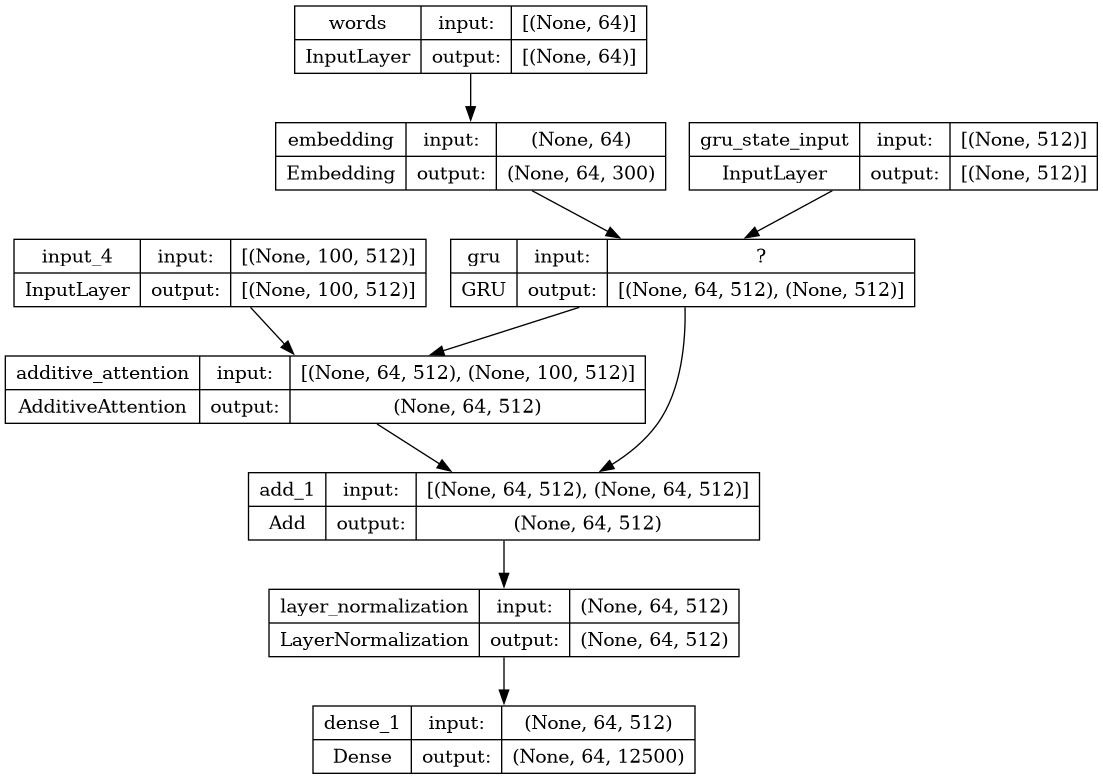

In [40]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

decoder_pred_model.summary()
tf.keras.utils.plot_model(decoder_pred_model, to_file='decoder_pred_model.png', show_shapes=True, show_layer_names=True)

### Saving Components in both HDF5 and SavedModel formats 

In [41]:
# Saving the Feature Extractor
# FEATURE_EXTRACTOR.save('feature_extractor.h5')
FEATURE_EXTRACTOR.save('feature_extractor')

# Saving the encoder
# encoder.save('encoder.h5')
encoder.save('encoder')

# Saving the decoder
# decoder.save('decoder.h5')
decoder.save('decoder')

# Saving the Train Image Caption Model (encoder and decoder merged)
# image_caption_train_model.save('image_caption_train_model.h5')
image_caption_train_model.save('image_caption_train_model')

# Saving the Decoder Prediction Model (For Inference Use)
# decoder_pred_model.save('decoder_pred_model.h5')
decoder_pred_model.save('decoder_pred_model')

### Saving and Loading the Tokernizer

In [42]:
# 1. Wrap the tokenizer in a Keras Model and save it
input_text = tf.keras.Input(shape=(1,), dtype=tf.string)
x = tokenizer(input_text)
tokenizer_model = tf.keras.Model(input_text, x)
tokenizer_model.save('tokenizer_model')

# 2. Load the tokenizer model
loaded_model = tf.keras.models.load_model('tokenizer_model', custom_objects={'standardize': standardize})
loaded_tokenizer = loaded_model.layers[1]

# 3. Compare the tokenizers
# Get the vocabulary of the original and loaded tokenizers
original_vocab = tokenizer.get_vocabulary()
loaded_vocab = loaded_tokenizer.get_vocabulary()

# Compare the vocabularies
if original_vocab == loaded_vocab:
    print("Tokenizers match! The tokenizer was saved and loaded correctly.")
else:
    print("Tokenizers do not match. There might be an issue with the saving/loading process.")

Tokenizers match! The tokenizer was saved and loaded correctly.


In [43]:
# # Lookup table: Word -> Index
# loaded_word_to_index = StringLookup(
#     mask_token="", vocabulary=loaded_tokenizer.get_vocabulary()
# )

# # Lookup table: Index -> Word
# loaded_index_to_word = StringLookup(
#     mask_token="", vocabulary=loaded_tokenizer.get_vocabulary(), invert=True
# )

### Loading Components

In [44]:
# # Loading the Feature Extractor
# FEATURE_EXTRACTOR = tf.keras.models.load_model('feature_extractor.h5', custom_objects=None, compile=False)

# # Loading the Feature Extractor
# encoder = tf.keras.models.load_model('encoder.h5', custom_objects=None, compile=False)

# # Loading the Tokenizer
# tokenizer = tf.saved_model.load('tokenizer_saved_model')

# # Recreate the Word to Index Mapping
# word_to_index = StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token="")

# # Recreate the Index to Word Mapping
# index_to_word = StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token="", invert=True)

# # Loading the Decoder Prediction Model
# decoder_pred_model = tf.keras.models.load_model('decoder_pred_model.h5', custom_objects=None, compile=False)

### Predict Funtion (Stochastic Sampling)

1. Initialize the GRU states as zero vectors.
1. Preprocess an input image, pass it to the encoder, and extract image features.
1. Setup word tokens of `<start>` to start captioning.
1. In the for loop, 
    - Pass word tokens (`dec_input`), GRU states (`gru_state`) and image features (`features`) to the prediction decoder and get predictions (`predictions`), and the updated GRU states.
    - Select Top-K words from logits, and choose a word probabilistically to avoid computing softmax over VOCAB_SIZE-sized vector.
    - Stop predicting when the model predicts the `<end>` token.
    - Replace the input word token with the predicted word token for the next step.

In [45]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

#   If you are using EfficientNetB3 below is the preprocessing steps for it.
    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)

#   If you are using InceptionResnetV2 below is the preprocessing steps for it.
#     img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
#     img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = img / 255
    
    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return filename, result

### Beam Search

In [46]:
def predict_caption_beam_search(filename, beam_width=3):
    # Preprocess the image
    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    
    # Extract features using the encoder
    features = encoder(tf.expand_dims(img, axis=0))

    # Start with the <start> token for each beam
    start_token = word_to_index("<start>")
    dec_input = tf.expand_dims([start_token], 0)
    gru_state = tf.zeros((1, ATTENTION_DIM))

    # Initial states of the beams
    beams = [(dec_input, gru_state, 0, [])]  # Each beam is a tuple (decoder_input, gru_state, score, caption_sequence)

    for i in range(MAX_CAPTION_LEN):
        new_beams = []
        for dec_input, gru_state, score, caption_sequence in beams:
            # Get predictions and update GRU state
            predictions, gru_state = decoder_pred_model([dec_input, gru_state, features])

            # Apply softmax to convert logits to probabilities
            predictions = tf.nn.softmax(predictions, axis=-1)

            # Get top k probabilities and their indices
            top_probs, top_idxs = tf.math.top_k(predictions, k=beam_width)

            # For each beam, add the top k possibilities
            for j in range(beam_width):
                next_word_idx = top_idxs[0][0][j].numpy()
                next_word = tokenizer.get_vocabulary()[next_word_idx]
                next_score = score + tf.math.log(top_probs[0][0][j])

                # If the next word is <end>, we complete the caption
                if next_word == "<end>":
                    return img, caption_sequence + [next_word]

                # Otherwise, we add the next word to the beam
                new_beam = (tf.expand_dims([next_word_idx], 0), gru_state, next_score, caption_sequence + [next_word])
                new_beams.append(new_beam)

        # Sort all possible beams by their score and select the top k to continue
        beams = sorted(new_beams, key=lambda beam: beam[2], reverse=True)[:beam_width]

    # If the loop ends because MAX_CAPTION_LEN is reached, return the highest scoring beam
    return img, max(beams, key=lambda beam: beam[2])[3]

In [47]:
def generate_captions_with_different_beam_widths(filename, max_beam_width=6):
    captions = {}
    for beam_width in range(1, max_beam_width + 1):
        _, caption = predict_caption_beam_search(filename, beam_width)
        captions[beam_width] = " ".join(caption[:-1]) + "."
        
    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    plt.imshow(img)
    plt.axis("off");
    return captions

Let's caption! 

Captions Generated with Different Beam Widths:

Beam Width 1: a baseball player is sliding into home plate.
Beam Width 2: a baseball player is sliding into home plate.
Beam Width 3: a baseball player sliding into home plate.
Beam Width 4: a baseball player sliding into home.
Beam Width 5: a baseball player sliding into home.


Captions Generated with Stochastic Approach:

a baseball player is sliding into home home plate as his teammate looks on.
a baseball player is sliding on base while a player attempts to tag him.
a baseball batter swinging at a ball while other players are watching.
a pitcher throws the ball for his home plate.
a baseball player is sliding into a tee.


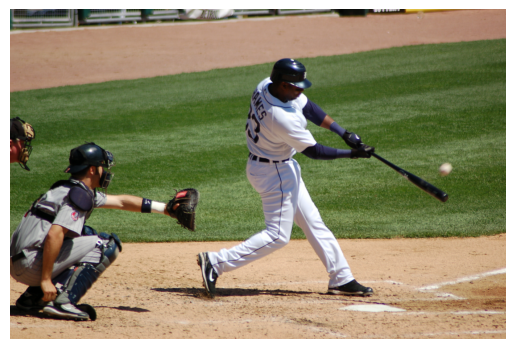

In [48]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/baseball.jpeg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a basketball player in a yellow jersey is dribbling the ball.
Beam Width 2: a basketball player in a yellow jersey is dribbling the ball.
Beam Width 3: a basketball player in a yellow jersey is dribbling the ball.
Beam Width 4: a basketball player is dribbling the ball.
Beam Width 5: a basketball player is dribbling the ball.


Captions Generated with Stochastic Approach:

basketball player making a shot with a yellow team member from the other team.
a man playing basketball in the olympics is shooting the ball.
a basketball player is dribbling a basketball towards the basket.
three basketball players are playing basketball.
a man in a white basketball uniform is dribbling a basketball.


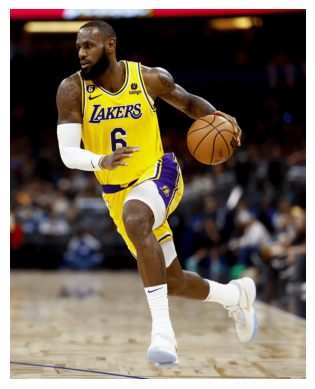

In [49]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/Basketball player in yellow dribbling on the court.jpg"

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a runner in a yellow shirt is running in the race.
Beam Width 2: a runner in a yellow shirt is running on the track.
Beam Width 3: a runner in a yellow shirt is running in a race.
Beam Width 4: a runner is running in the race.
Beam Width 5: a runner is running in the race.


Captions Generated with Stochastic Approach:

the runner in the green shorts is running on the track.
a runner is running on a track in the race with a referee cheering him on in the background.
two basketball players in yellow running on a court.
a man running in a marathon.
a man runs down the street with a basketball in a blue uniform.


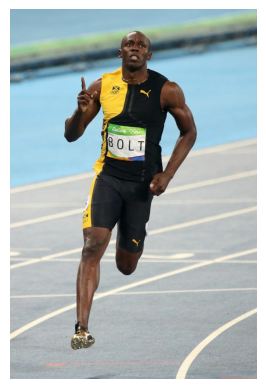

In [50]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/Usian Bolt Running.jpeg"  

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a woman in a green shirt and a man in a green shirt are playing tennis.
Beam Width 2: a woman in a green shirt and white shorts is playing tennis.
Beam Width 3: a woman in a green shirt is playing tennis.
Beam Width 4: a woman in a green shirt is playing tennis.
Beam Width 5: a woman is playing tennis.


Captions Generated with Stochastic Approach:

a woman in a green shirt is playing tennis.
a female tennis player with a green shirt and blue shorts is hitting the tennis ball.
a young woman is playing tennis.
the lady on the white tennis racket is holding the tennis racket on the racket.
a tennis player is hitting a ball with his racket.


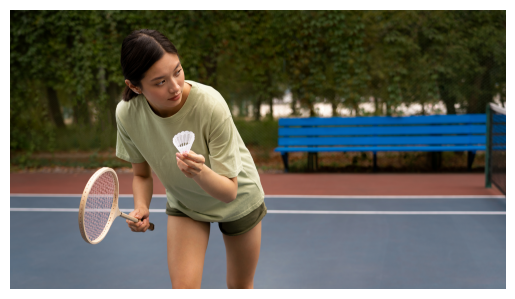

In [51]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/front-view-woman-playing-badminton.jpg"

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a man in a red shirt is surfing on a wave.
Beam Width 2: a man surfing in the ocean.
Beam Width 3: a man surfing in the ocean.
Beam Width 4: a man surfing.
Beam Width 5: a man surfing.


Captions Generated with Stochastic Approach:

a man surfing in rough waves at the beach.
a surfer riding the waves.
a surfer catching the waves in his hand.
people surfing in the middle of a lake.
a man in a wetsuit rides a surfboard on a wave.


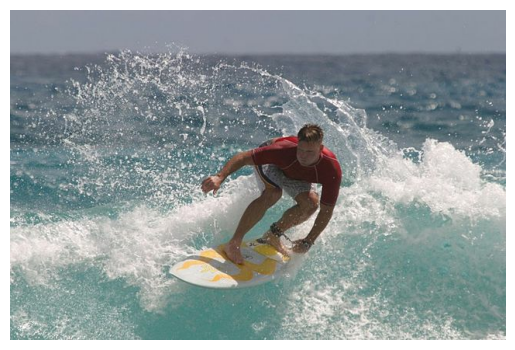

In [52]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/surf.jpeg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a white dog is running through a field of grass.
Beam Width 2: a white dog runs through the grass.
Beam Width 3: a white dog runs through the grass.
Beam Width 4: a white dog runs through the grass.
Beam Width 5: a white dog runs through the grass.


Captions Generated with Stochastic Approach:

a white and brown dog runs through the field.
a white furry dog is walking through some grass.
a shaggy dog is playing in water with a toy in its mouth.
a black and white dog is running through the grass.
a fluffy white dog is running through a field of grass.


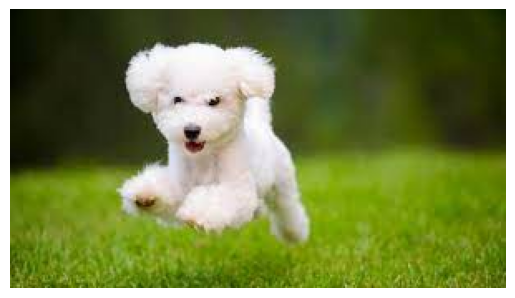

In [53]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/White puppy running on the grass field.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a man is eating food at a restaurant.
Beam Width 2: a man is eating a meal.
Beam Width 3: a man is eating food.
Beam Width 4: a man is eating food.
Beam Width 5: a man is eating food.


Captions Generated with Stochastic Approach:

a man with a yellow shirt eating food from a restaurant.
a woman holding a yellow bag is eating some food at a table.
this man is eating some food in a restaurant.
a man is eating noodles at a table.
a man in a black shirt eating food.


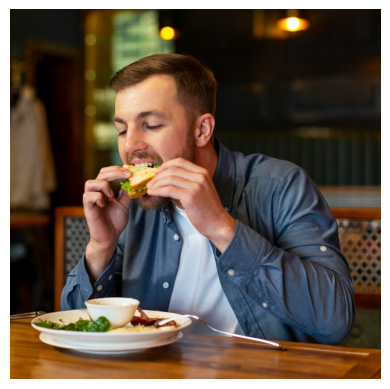

In [54]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/man eating sandwich indoor.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a man in a white shirt is taking a picture of a camera.
Beam Width 2: a man taking a picture of a camera.
Beam Width 3: a man taking a picture of a camera.
Beam Width 4: a man taking a picture.
Beam Width 5: a man taking a picture.


Captions Generated with Stochastic Approach:

a man in a blue shirt takes a picture with a camera.
a man holding camera taking a picture in a building.
man taking photographs photograph.
a person dressed in a white shirt and brown pants is taking a picture.
a man taking pictures with one camera.


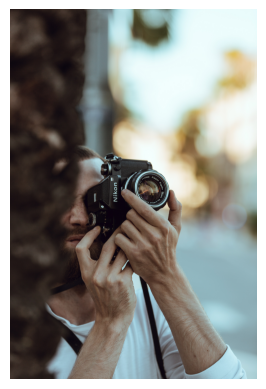

In [55]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/sebastien-bourguet-ZI1FT0B68K8-unsplash.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a young boy in a yellow shirt is taking a picture of a tree.
Beam Width 2: a man in a yellow shirt is taking a picture.
Beam Width 3: a man in a yellow shirt is taking a picture.
Beam Width 4: a man in a yellow shirt is taking a picture.
Beam Width 5: a man in a yellow shirt is taking a picture.


Captions Generated with Stochastic Approach:

a woman in a yellow top is taking photographs.
an older lady in a beige shirt is looking a camera through a camera.
a young person wearing a white shirt and a yellow hard hat is using a camera.
a young boy wearing a light blue shirt is holding a camera.
a man taking a break of nature.


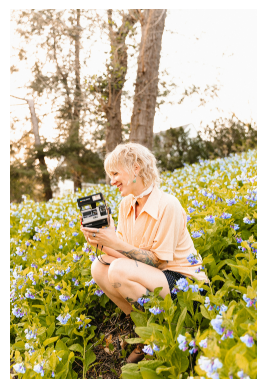

In [56]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/megan-ruth-adUFpGiyjCY-unsplash.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a man with a beard is sitting on a laptop.
Beam Width 2: a man in a black shirt is using a laptop.
Beam Width 3: a man in a black shirt is using a laptop.
Beam Width 4: a man in a black shirt is using a laptop.
Beam Width 5: a man is using a laptop.


Captions Generated with Stochastic Approach:

an elderly man and a woman sit at the table with their laptops in their hands.
a young man sits in the shade of [UNK] using a laptop.
a person is taking a break from working on a laptop in a public room.
a man is sitting in a chair on a laptop computer and is looking down at the camera.
an elderly woman wearing a white blouse sits on a red chair with her hand on her shoulder at the camera while another man in a black shirt looks on in a background.


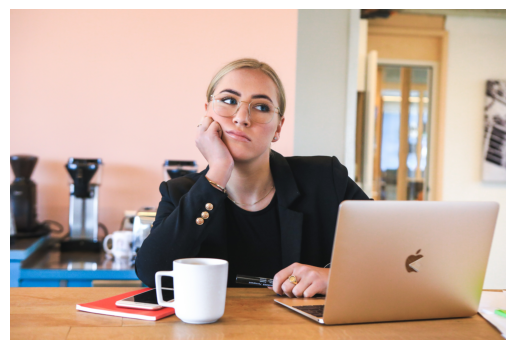

In [57]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/magnet-me-LDcC7aCWVlo-unsplash.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a man in a wheelchair race on a road.
Beam Width 2: a man riding a bicycle down the road.
Beam Width 3: a man riding a bicycle down the road.
Beam Width 4: a bicyclist is racing down a road.
Beam Width 5: a man is riding a bicycle.


Captions Generated with Stochastic Approach:

two cyclists in the middle of a race.
three bikers riding down the street on a sunny day.
two bicyclists riding down a road along a road.
two bicyclists are racing down the road.
two people are riding bikes on a road in the middle of the road.


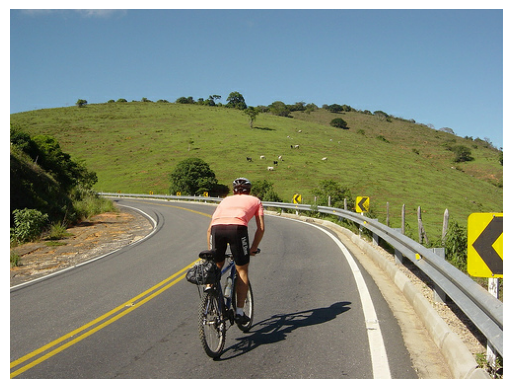

In [58]:
filename = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/110595925.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: a black and white bird is standing on a snowy field.
Beam Width 2: a black and white bird is standing on a snowy field.
Beam Width 3: a black and white bird is standing in the middle.
Beam Width 4: a black and white bird is standing in the middle.
Beam Width 5: a black and white bird is standing in the middle.


Captions Generated with Stochastic Approach:

a black man and a woman are looking at each other.
the two men are playing tugofwar on the rocks.
the lady is holding onto the baby in the stroller.
a black and white bird is standing near a large bird 's eye view.
a small boy and an older woman walking through a large snowy area.


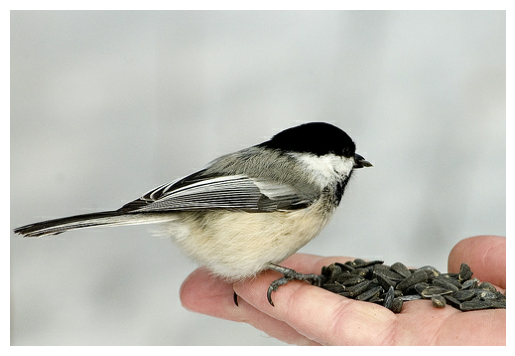

In [59]:
filename = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/111766423.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Captions Generated with Different Beam Widths:

Beam Width 1: two martial artists sparring in a martial arts competition.
Beam Width 2: two martial artists sparring.
Beam Width 3: two martial artists sparring.
Beam Width 4: two martial artists sparring.
Beam Width 5: two martial artists sparring.


Captions Generated with Stochastic Approach:

two boys practice martial arts.
two martial artists fighting on a white mat.
a boy practicing karate moves down a mat.
two martial artists are practicing karate moves a mat.
two men are fighting in martial arts.


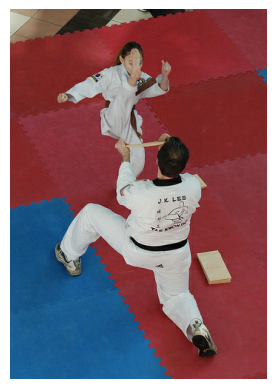

In [60]:
filename = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/101362133.jpg" 

captions = generate_captions_with_different_beam_widths(filename, 5)
# Print the generated captions
print('Captions Generated with Different Beam Widths:\n')
for beam_width, caption in captions.items():
    print(f"Beam Width {beam_width}: {caption}")
    
print("\n")
print('Captions Generated with Stochastic Approach:\n')
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

In [61]:
filename = "/kaggle/input/format-text-file-for-flickr30k/Sample Pictures/baseball.jpeg" 

image, caption = predict_caption(filename)
print('Raw Caption:\n')
caption

Raw Caption:



['a',
 'batter',
 'hits',
 'a',
 'softball',
 'while',
 'the',
 'pitcher',
 'in',
 'the',
 'blue',
 'uniform',
 'is',
 'trying',
 'to',
 'bat',
 'the',
 'ball',
 '<end>']

In [62]:
print('Processed Caption:\n')
print(" ".join(caption[:-1]) + ".")

Processed Caption:

a batter hits a softball while the pitcher in the blue uniform is trying to bat the ball.
